G05: Jakober, Winkler, Matzinger, Salzmann

# CNN - CIFAR10 - Data Augmentation

## Loading the packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, v2
from torchsummary import summary

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [3]:
print(f'Your torch version is {torch.__version__}')
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

Your torch version is 2.6.0


device(type='mps')

### Downloading CIFAR10 dataset

Define a function to plot some images from CIFAR and load the dataset.

In [4]:
Transform = ToTensor()
train_data = datasets.CIFAR10(
    root = 'data',
    train = True,                         
    transform = Transform, 
    download = True,            
)

test_data = datasets.CIFAR10(
    root = 'data', 
    train = False, 
    transform = Transform,
    download = True
)

In [5]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

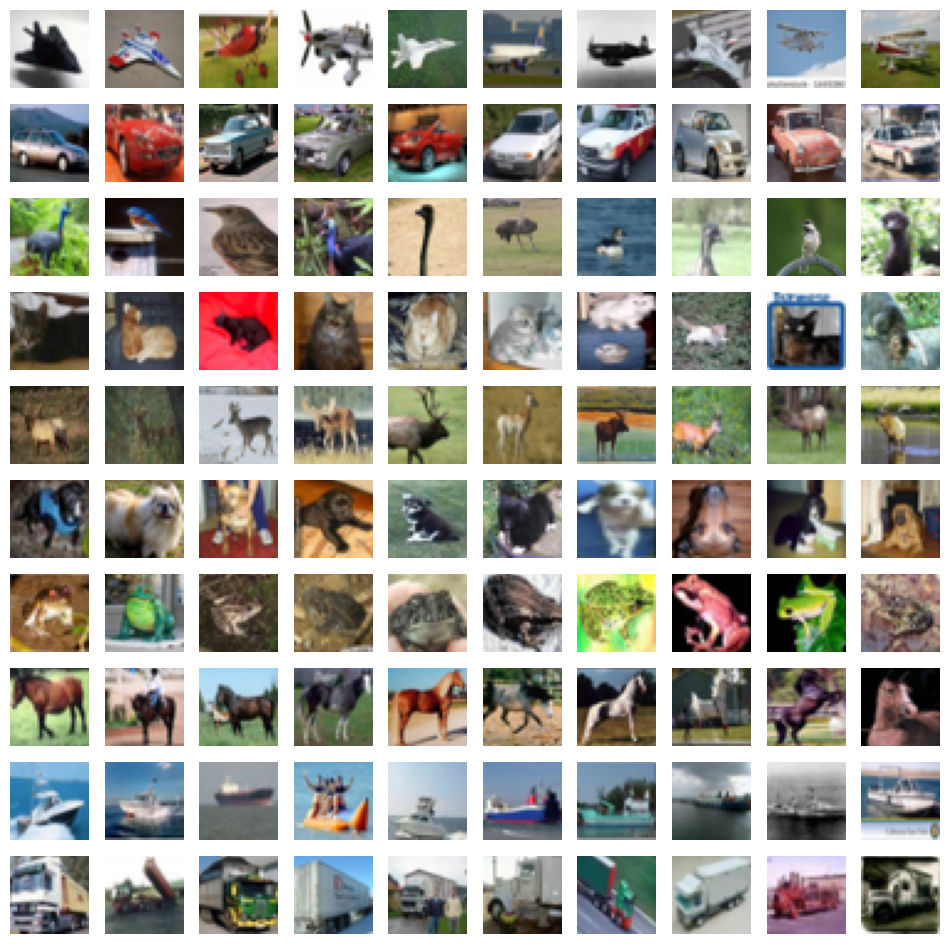

Training input shape :  (50000, 32, 32, 3)
Training output shape:  (50000,)
Testing input shape  :  (10000, 32, 32, 3)
Testing output shape :  10000


In [7]:
def show_imgs(X, y):
    """Display a 10x10 grid of images, grouped by class."""
    plt.figure(1, figsize=(12,12))
    
    for i in range(10):
        class_indices = np.where(y == i)[0]
        selected_indices = class_indices[:10]
        
        for j, idx in enumerate(selected_indices):
            plt.subplot(10, 10, i * 10 + j + 1)
            plt.imshow(X[idx].astype(np.float32) / 255)
            plt.axis('off')
            
    plt.show()

X_train = train_data.data
y_train = np.array(train_data.targets)

show_imgs(X_train, y_train)

print('Training input shape : ', X_train.shape)
print('Training output shape: ', y_train.shape)
print('Testing input shape  : ', test_data.data.shape)
print('Testing output shape : ', len(test_data.targets))

### Preprocessing data

In [8]:
train_data, val_data = torch.utils.data.random_split(train_data, [40000, 10000])

In [9]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

## Define the network
The neural network will be a CNN. Follow the structure given in the exercise 1.

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(8*8*32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.fc(x)

model = CNN()
summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            9,248
├─Conv2d: 1-3                            9,248
├─ReLU: 1-4                              --
├─MaxPool2d: 1-5                         --
├─Flatten: 1-6                           --
├─Linear: 1-7                            20,490
Total params: 39,882
Trainable params: 39,882
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            9,248
├─Conv2d: 1-3                            9,248
├─ReLU: 1-4                              --
├─MaxPool2d: 1-5                         --
├─Flatten: 1-6                           --
├─Linear: 1-7                            20,490
Total params: 39,882
Trainable params: 39,882
Non-trainable params: 0

## Compile and train the network

When compiling the model, we need to specify the loss function, the optimizer and the metrics we want to track during the training. In Keras, we need to call the methods `compile()` and `fit()`. We will train through E epochs, using batches of size B, as specified in the exercise 1.

- The `categorical_crossentropy` loss is relevant for multiclass, single-label classification problem. Categorical is used because there are 10 classes to predict from. If there were 2 classes, we would have used `binary_crossentropy`.
- The `adam` optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is defining the update rule for the weights of the neurons during backpropagation gradients.

In [11]:
def train_eval(model, train_loader, val_loader, optimizer, criterion, n_epochs):

    model.to(device)

    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_acc = []
    epoch_val_acc = []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        train_corr = 0

        print(f'\nEpoch {epoch+1}/{n_epochs}')
        print('----------')
        for X_train, y_train in tqdm(train_loader, desc=f'Train Epoch {epoch+1}/{n_epochs}'):
            X_train, y_train = X_train.to(device), y_train.to(device)

            optimizer.zero_grad()
            output = model(X_train)
            loss = criterion(output, y_train)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, y_pred = torch.max(output, dim=1)
            train_corr += torch.sum(y_pred == y_train).item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_corr / len(train_loader.dataset)

        epoch_train_losses.append(avg_train_loss)
        epoch_train_acc.append(train_acc)

        val_loss = 0
        val_corr = 0

        for X_val, y_val in tqdm(val_loader, desc=f'Val Epoch {epoch+1}/{n_epochs}'):
            X_val, y_val = X_val.to(device), y_val.to(device)

            output = model(X_val)
            loss = criterion(output, y_val)

            val_loss += loss.item()
            _, y_pred = torch.max(output, dim=1)
            val_corr += torch.sum(y_pred == y_val).item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_corr / len(val_loader.dataset)

        epoch_val_losses.append(avg_val_loss)
        epoch_val_acc.append(val_acc)

        print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.4f}\nVal Loss: {avg_val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

    return epoch_train_losses, epoch_val_losses, epoch_train_acc, epoch_val_acc

In [12]:
n_epochs = 10
lr = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses, train_acc, val_acc = train_eval(model, train_loader, val_loader, optimizer, criterion, n_epochs)


Epoch 1/10
----------


Val Epoch 1/10: 100%|██████████| 79/79 [00:00<00:00, 87.41it/s] 


Train Loss: 1.6791, Train Accuracy: 0.3996
Val Loss: 1.4246, Val Accuracy: 0.4945

Epoch 2/10
----------


Val Epoch 2/10: 100%|██████████| 79/79 [00:00<00:00, 101.04it/s]


Train Loss: 1.3012, Train Accuracy: 0.5384
Val Loss: 1.2628, Val Accuracy: 0.5532

Epoch 3/10
----------


Val Epoch 3/10: 100%|██████████| 79/79 [00:00<00:00, 87.54it/s]


Train Loss: 1.1520, Train Accuracy: 0.5969
Val Loss: 1.1424, Val Accuracy: 0.6058

Epoch 4/10
----------


Val Epoch 4/10: 100%|██████████| 79/79 [00:00<00:00, 87.85it/s]


Train Loss: 1.0366, Train Accuracy: 0.6398
Val Loss: 1.1035, Val Accuracy: 0.6218

Epoch 5/10
----------


Val Epoch 5/10: 100%|██████████| 79/79 [00:00<00:00, 96.71it/s] 


Train Loss: 0.9514, Train Accuracy: 0.6696
Val Loss: 0.9967, Val Accuracy: 0.6552

Epoch 6/10
----------


Val Epoch 6/10: 100%|██████████| 79/79 [00:00<00:00, 89.29it/s] 


Train Loss: 0.8999, Train Accuracy: 0.6869
Val Loss: 0.9925, Val Accuracy: 0.6644

Epoch 7/10
----------


Val Epoch 7/10: 100%|██████████| 79/79 [00:00<00:00, 94.51it/s] 


Train Loss: 0.8548, Train Accuracy: 0.7013
Val Loss: 0.9882, Val Accuracy: 0.6630

Epoch 8/10
----------


Val Epoch 8/10: 100%|██████████| 79/79 [00:00<00:00, 87.78it/s]


Train Loss: 0.8224, Train Accuracy: 0.7128
Val Loss: 0.9226, Val Accuracy: 0.6857

Epoch 9/10
----------


Val Epoch 9/10: 100%|██████████| 79/79 [00:00<00:00, 95.27it/s] 


Train Loss: 0.7844, Train Accuracy: 0.7259
Val Loss: 0.9176, Val Accuracy: 0.6881

Epoch 10/10
----------


Val Epoch 10/10: 100%|██████████| 79/79 [00:00<00:00, 91.83it/s]

Train Loss: 0.7566, Train Accuracy: 0.7379
Val Loss: 0.9093, Val Accuracy: 0.6885


## Evaluate the network

We can do this at three levels: (1) plot of the loss during the training phase, (2) overall accuracy evaluation on test set and (3) per class evaluation with confusion matrix on test set.

### Loss and accuracy evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

In [13]:
def plot_loss_curve(n_epochs, train_losses, val_losses, train_acc, val_acc, y_trues=None, y_preds=None, title=None):
    i = 3 if y_trues is not None and y_preds is not None else 2
    
    fig, ax = plt.subplots(1, i, figsize=(24,8), layout='tight')

    ax[0].plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
    ax[0].plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_xticks(range(1, n_epochs+1))
    ax[0].set_ylabel('Loss')
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(range(1, n_epochs + 1), train_acc, label='Training Accuracy')
    ax[1].plot(range(1, n_epochs + 1), val_acc, label='Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_xticks(range(1, n_epochs+1))
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim(0,1)
    ax[1].grid()
    ax[1].legend()

    if i == 3:
        cm = confusion_matrix(y_trues, y_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax[2])

    fig.suptitle(title)
    plt.show()

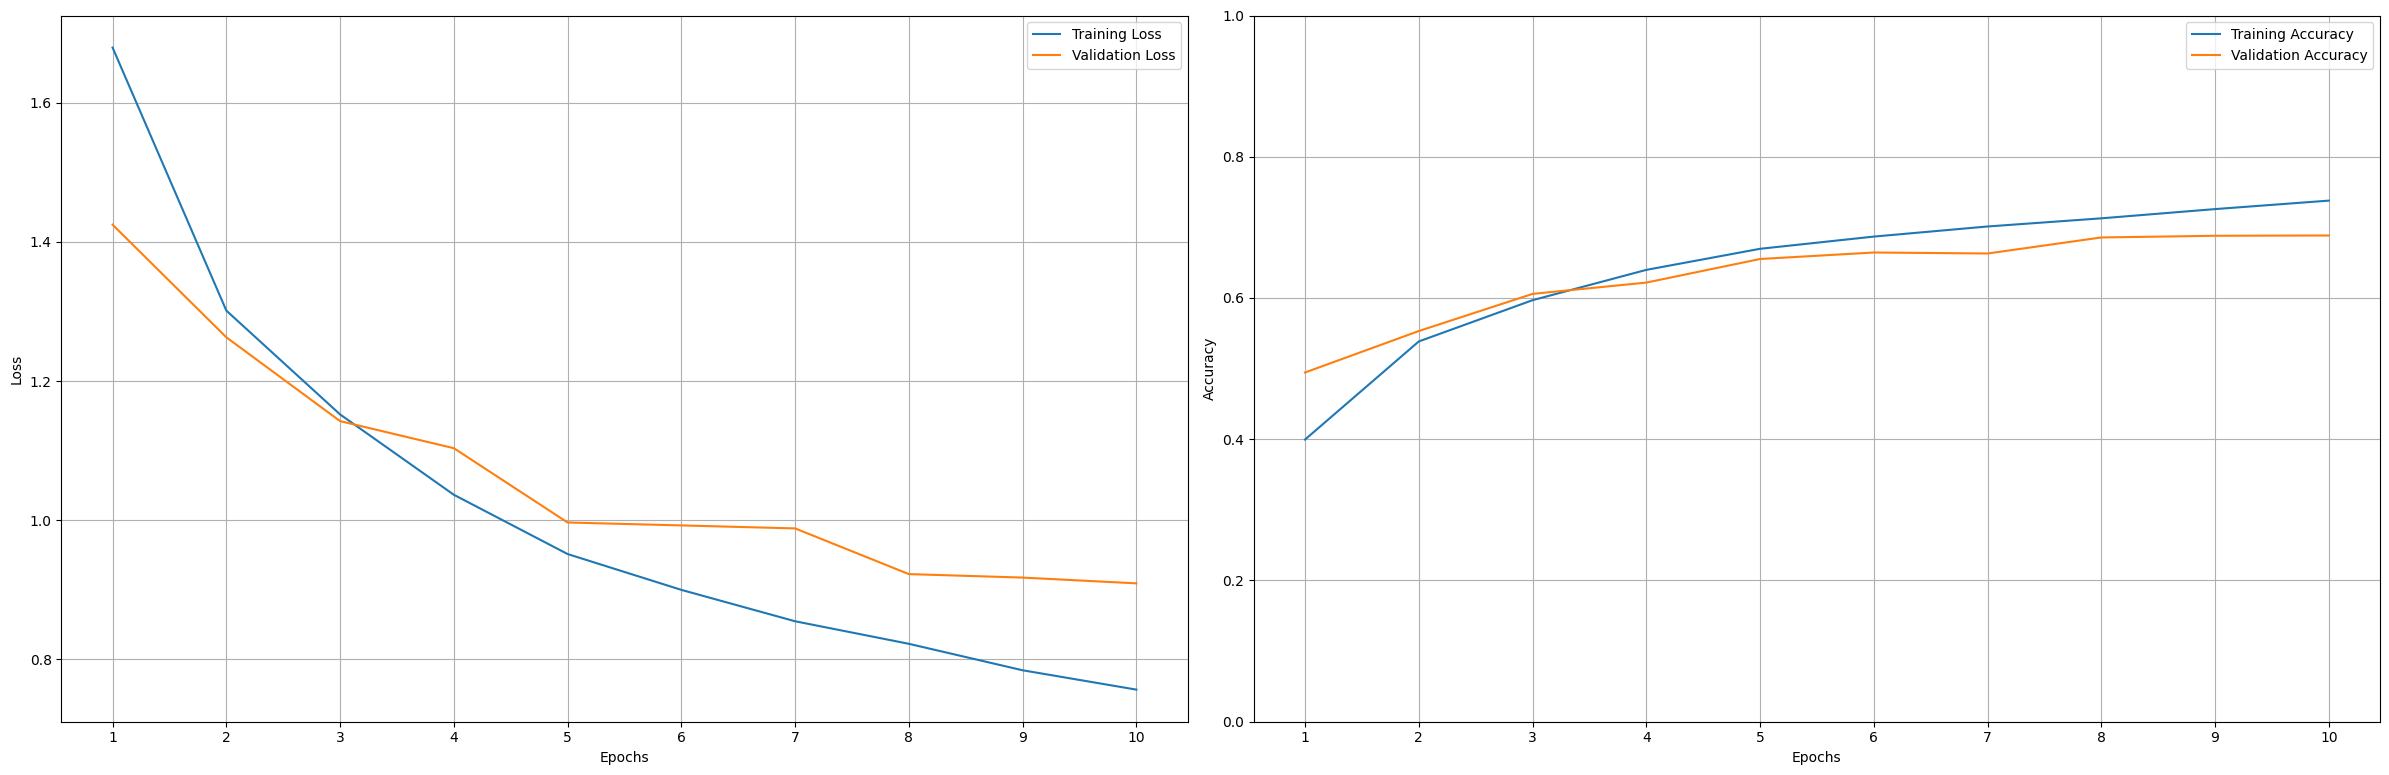

In [14]:
plot_loss_curve(n_epochs, train_losses, val_losses, train_acc, val_acc)

### Model evaluation
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [15]:
def eval(model, test_loader, criterion):
    y_preds = []
    y_trues = []

    model.to(device)
    test_loss = 0
    test_corr = 0

    model.eval()
    for X_test, y_test in tqdm(test_loader):
        X_test, y_test = X_test.to(device), y_test.to(device)

        output = model(X_test)
        loss = criterion(output, y_test)

        test_loss += loss.item()
        _, y_pred = torch.max(output, dim=1)
        test_corr += torch.sum(y_pred == y_test).item()

        y_preds.append(y_pred.cpu())
        y_trues.append(y_test.cpu())

    y_preds = torch.cat(y_preds).numpy()
    y_trues = torch.cat(y_trues).numpy()

    avg_test_loss = test_loss / len(test_loader)
    test_acc = test_corr / len(test_loader.dataset)

    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}')

    return test_acc, y_trues, y_preds

In [16]:
test_acc, y_trues, y_preds = eval(model, test_loader, criterion)

100%|██████████| 79/79 [00:00<00:00, 108.51it/s]

Test Loss: 0.9066, Test Accuracy: 0.69


### Confusion matrix
We can call the `predict()` function to get the predicted classes. The output array of ground truth `y_test` and the predicted classes can then be fed to the `confusion_matrix()` function of [sklearn metrics package](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix).

In [17]:
def plot_cm(y_trues, y_preds):
    cm = confusion_matrix(y_trues, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

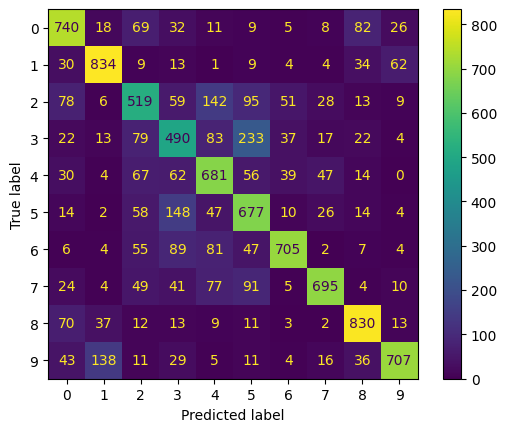

In [18]:
plot_cm(y_trues, y_preds)

## Data Augmentation

Overfitting can be caused by having networks with too many parameters that are trained on too few samples. Through training, the model learns *by hart* and generalizes poorly.

**Data augmentation** takes the approach of generating artificially more training data from existing training samples. For images, data augmentation is performed via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will not see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ```ImageDataGenerator``` instance.

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.

In [19]:
config = {
    'rotation': v2.Compose([
                            v2.RandomRotation((0, 180)),
                            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                            v2.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
                        ]),
    'rotation_translation': v2.Compose([
                            v2.RandomRotation((0, 180)),
                            v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                            v2.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
                        ]),
    'rotation_translation_shearing': v2.Compose([
                            v2.RandomRotation((0, 180)),
                            v2.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=20),
                            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                            v2.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
                        ]),
    'rotation_translation_shearing_zoom': v2.Compose([
                        v2.RandomRotation((0, 180)),
                        v2.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=20, scale=(0.8, 1.2)),
                        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                        v2.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
                        ]),
}


In [20]:
def transform_datasets(transformation):
    
    train_data = datasets.CIFAR10(
        root = 'data',
        train = True,                         
        transform = transformation, 
        download = True,            
    )

    test_data = datasets.CIFAR10(
        root = 'data',
        train = False, 
        transform = ToTensor(),
        download = True
    )

    return train_data, test_data

In [21]:
results = {}

n_epochs = 10
lr = 0.001

for name, transformation in config.items():
    
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_data, test_data = transform_datasets(transformation)
    train_data, val_data = torch.utils.data.random_split(train_data, [40000, 10000])

    for data, loader, shuffle in zip([train_data, val_data, test_data], [train_loader, val_loader, test_loader], [True, False, False]):
        loader = DataLoader(data, batch_size=128, shuffle=shuffle)

    train_losses, val_losses, train_acc, val_acc = train_eval(model, train_loader, val_loader, optimizer, criterion, n_epochs)

    test_acc, y_trues, y_preds = eval(model, test_loader, criterion)
    
    results[name] = [train_losses, val_losses, train_acc, val_acc, y_trues, y_preds, train_acc[-1], test_acc]


Epoch 1/10
----------


Val Epoch 1/10: 100%|██████████| 79/79 [00:00<00:00, 99.90it/s] 


Train Loss: 1.6644, Train Accuracy: 0.4049
Val Loss: 1.4091, Val Accuracy: 0.4935

Epoch 2/10
----------


Val Epoch 2/10: 100%|██████████| 79/79 [00:00<00:00, 97.79it/s] 


Train Loss: 1.2840, Train Accuracy: 0.5496
Val Loss: 1.2204, Val Accuracy: 0.5705

Epoch 3/10
----------


Val Epoch 3/10: 100%|██████████| 79/79 [00:00<00:00, 93.09it/s]


Train Loss: 1.1384, Train Accuracy: 0.6032
Val Loss: 1.1325, Val Accuracy: 0.6052

Epoch 4/10
----------


Val Epoch 4/10: 100%|██████████| 79/79 [00:00<00:00, 96.67it/s] 


Train Loss: 1.0315, Train Accuracy: 0.6395
Val Loss: 1.0848, Val Accuracy: 0.6233

Epoch 5/10
----------


Val Epoch 5/10: 100%|██████████| 79/79 [00:00<00:00, 99.22it/s] 


Train Loss: 0.9628, Train Accuracy: 0.6646
Val Loss: 0.9908, Val Accuracy: 0.6565

Epoch 6/10
----------


Val Epoch 6/10: 100%|██████████| 79/79 [00:00<00:00, 99.65it/s] 


Train Loss: 0.9102, Train Accuracy: 0.6818
Val Loss: 0.9991, Val Accuracy: 0.6519

Epoch 7/10
----------


Val Epoch 7/10: 100%|██████████| 79/79 [00:01<00:00, 77.79it/s]


Train Loss: 0.8665, Train Accuracy: 0.6984
Val Loss: 0.9790, Val Accuracy: 0.6594

Epoch 8/10
----------


Val Epoch 8/10: 100%|██████████| 79/79 [00:00<00:00, 99.91it/s] 


Train Loss: 0.8393, Train Accuracy: 0.7067
Val Loss: 0.9418, Val Accuracy: 0.6791

Epoch 9/10
----------


Val Epoch 9/10: 100%|██████████| 79/79 [00:00<00:00, 100.67it/s]


Train Loss: 0.8043, Train Accuracy: 0.7201
Val Loss: 0.9489, Val Accuracy: 0.6745

Epoch 10/10
----------


Val Epoch 10/10: 100%|██████████| 79/79 [00:00<00:00, 98.39it/s] 


Train Loss: 0.7834, Train Accuracy: 0.7268
Val Loss: 0.9288, Val Accuracy: 0.6848


100%|██████████| 79/79 [00:00<00:00, 110.63it/s]


Test Loss: 0.9259, Test Accuracy: 0.69

Epoch 1/10
----------


Val Epoch 1/10: 100%|██████████| 79/79 [00:00<00:00, 96.98it/s] 


Train Loss: 1.6774, Train Accuracy: 0.4018
Val Loss: 1.5126, Val Accuracy: 0.4603

Epoch 2/10
----------


Val Epoch 2/10: 100%|██████████| 79/79 [00:00<00:00, 98.71it/s] 


Train Loss: 1.3508, Train Accuracy: 0.5198
Val Loss: 1.2889, Val Accuracy: 0.5427

Epoch 3/10
----------


Val Epoch 3/10: 100%|██████████| 79/79 [00:00<00:00, 99.98it/s] 


Train Loss: 1.2082, Train Accuracy: 0.5745
Val Loss: 1.1796, Val Accuracy: 0.5910

Epoch 4/10
----------


Val Epoch 4/10: 100%|██████████| 79/79 [00:00<00:00, 99.58it/s] 


Train Loss: 1.0953, Train Accuracy: 0.6166
Val Loss: 1.0947, Val Accuracy: 0.6241

Epoch 5/10
----------


Val Epoch 5/10: 100%|██████████| 79/79 [00:00<00:00, 99.23it/s] 


Train Loss: 1.0133, Train Accuracy: 0.6466
Val Loss: 1.0381, Val Accuracy: 0.6387

Epoch 6/10
----------


Val Epoch 6/10: 100%|██████████| 79/79 [00:00<00:00, 99.51it/s] 


Train Loss: 0.9524, Train Accuracy: 0.6668
Val Loss: 1.0023, Val Accuracy: 0.6580

Epoch 7/10
----------


Val Epoch 7/10: 100%|██████████| 79/79 [00:00<00:00, 81.20it/s]


Train Loss: 0.8960, Train Accuracy: 0.6878
Val Loss: 0.9536, Val Accuracy: 0.6749

Epoch 8/10
----------


Val Epoch 8/10: 100%|██████████| 79/79 [00:00<00:00, 85.79it/s] 


Train Loss: 0.8538, Train Accuracy: 0.7035
Val Loss: 0.9282, Val Accuracy: 0.6843

Epoch 9/10
----------


Val Epoch 9/10: 100%|██████████| 79/79 [00:00<00:00, 89.94it/s]


Train Loss: 0.8222, Train Accuracy: 0.7147
Val Loss: 0.9515, Val Accuracy: 0.6727

Epoch 10/10
----------


Val Epoch 10/10: 100%|██████████| 79/79 [00:01<00:00, 75.48it/s]


Train Loss: 0.7882, Train Accuracy: 0.7257
Val Loss: 0.9241, Val Accuracy: 0.6861


100%|██████████| 79/79 [00:00<00:00, 98.08it/s] 


Test Loss: 0.9102, Test Accuracy: 0.69

Epoch 1/10
----------


Val Epoch 1/10: 100%|██████████| 79/79 [00:01<00:00, 65.74it/s]


Train Loss: 1.6818, Train Accuracy: 0.3957
Val Loss: 1.4321, Val Accuracy: 0.4753

Epoch 2/10
----------


Val Epoch 2/10: 100%|██████████| 79/79 [00:01<00:00, 65.25it/s]


Train Loss: 1.3138, Train Accuracy: 0.5342
Val Loss: 1.2450, Val Accuracy: 0.5579

Epoch 3/10
----------


Val Epoch 3/10: 100%|██████████| 79/79 [00:00<00:00, 85.07it/s]


Train Loss: 1.1597, Train Accuracy: 0.5919
Val Loss: 1.1204, Val Accuracy: 0.6052

Epoch 4/10
----------


Val Epoch 4/10: 100%|██████████| 79/79 [00:00<00:00, 88.57it/s]


Train Loss: 1.0527, Train Accuracy: 0.6310
Val Loss: 1.0537, Val Accuracy: 0.6323

Epoch 5/10
----------


Val Epoch 5/10: 100%|██████████| 79/79 [00:00<00:00, 97.69it/s] 


Train Loss: 0.9769, Train Accuracy: 0.6583
Val Loss: 1.0403, Val Accuracy: 0.6426

Epoch 6/10
----------


Val Epoch 6/10: 100%|██████████| 79/79 [00:00<00:00, 95.45it/s]


Train Loss: 0.9216, Train Accuracy: 0.6793
Val Loss: 1.0058, Val Accuracy: 0.6551

Epoch 7/10
----------


Val Epoch 7/10: 100%|██████████| 79/79 [00:00<00:00, 94.23it/s] 


Train Loss: 0.8747, Train Accuracy: 0.6970
Val Loss: 0.9457, Val Accuracy: 0.6721

Epoch 8/10
----------


Val Epoch 8/10: 100%|██████████| 79/79 [00:00<00:00, 100.32it/s]


Train Loss: 0.8314, Train Accuracy: 0.7120
Val Loss: 0.9360, Val Accuracy: 0.6804

Epoch 9/10
----------


Val Epoch 9/10: 100%|██████████| 79/79 [00:00<00:00, 100.55it/s]


Train Loss: 0.7987, Train Accuracy: 0.7223
Val Loss: 0.9285, Val Accuracy: 0.6787

Epoch 10/10
----------


Val Epoch 10/10: 100%|██████████| 79/79 [00:00<00:00, 98.92it/s] 


Train Loss: 0.7734, Train Accuracy: 0.7323
Val Loss: 0.9821, Val Accuracy: 0.6704


100%|██████████| 79/79 [00:00<00:00, 106.81it/s]


Test Loss: 0.9717, Test Accuracy: 0.67

Epoch 1/10
----------


Val Epoch 1/10: 100%|██████████| 79/79 [00:00<00:00, 98.28it/s] 


Train Loss: 1.6526, Train Accuracy: 0.4067
Val Loss: 1.3490, Val Accuracy: 0.5203

Epoch 2/10
----------


Val Epoch 2/10: 100%|██████████| 79/79 [00:00<00:00, 99.33it/s] 


Train Loss: 1.2747, Train Accuracy: 0.5529
Val Loss: 1.2211, Val Accuracy: 0.5760

Epoch 3/10
----------


Val Epoch 3/10: 100%|██████████| 79/79 [00:00<00:00, 101.00it/s]


Train Loss: 1.1331, Train Accuracy: 0.6051
Val Loss: 1.1203, Val Accuracy: 0.6159

Epoch 4/10
----------


Val Epoch 4/10: 100%|██████████| 79/79 [00:01<00:00, 78.25it/s]


Train Loss: 1.0315, Train Accuracy: 0.6417
Val Loss: 1.0349, Val Accuracy: 0.6409

Epoch 5/10
----------


Val Epoch 5/10: 100%|██████████| 79/79 [00:00<00:00, 86.84it/s]


Train Loss: 0.9587, Train Accuracy: 0.6704
Val Loss: 1.0059, Val Accuracy: 0.6566

Epoch 6/10
----------


Val Epoch 6/10: 100%|██████████| 79/79 [00:00<00:00, 94.26it/s] 


Train Loss: 0.8934, Train Accuracy: 0.6911
Val Loss: 0.9699, Val Accuracy: 0.6687

Epoch 7/10
----------


Val Epoch 7/10: 100%|██████████| 79/79 [00:01<00:00, 77.39it/s]


Train Loss: 0.8566, Train Accuracy: 0.7038
Val Loss: 0.9541, Val Accuracy: 0.6778

Epoch 8/10
----------


Val Epoch 8/10: 100%|██████████| 79/79 [00:00<00:00, 89.38it/s]


Train Loss: 0.8222, Train Accuracy: 0.7164
Val Loss: 0.9653, Val Accuracy: 0.6765

Epoch 9/10
----------


Val Epoch 9/10: 100%|██████████| 79/79 [00:00<00:00, 92.25it/s]


Train Loss: 0.7898, Train Accuracy: 0.7290
Val Loss: 0.9187, Val Accuracy: 0.6868

Epoch 10/10
----------


Val Epoch 10/10: 100%|██████████| 79/79 [00:00<00:00, 97.33it/s] 


Train Loss: 0.7586, Train Accuracy: 0.7408
Val Loss: 0.9152, Val Accuracy: 0.6900


100%|██████████| 79/79 [00:00<00:00, 107.50it/s]

Test Loss: 0.8987, Test Accuracy: 0.69


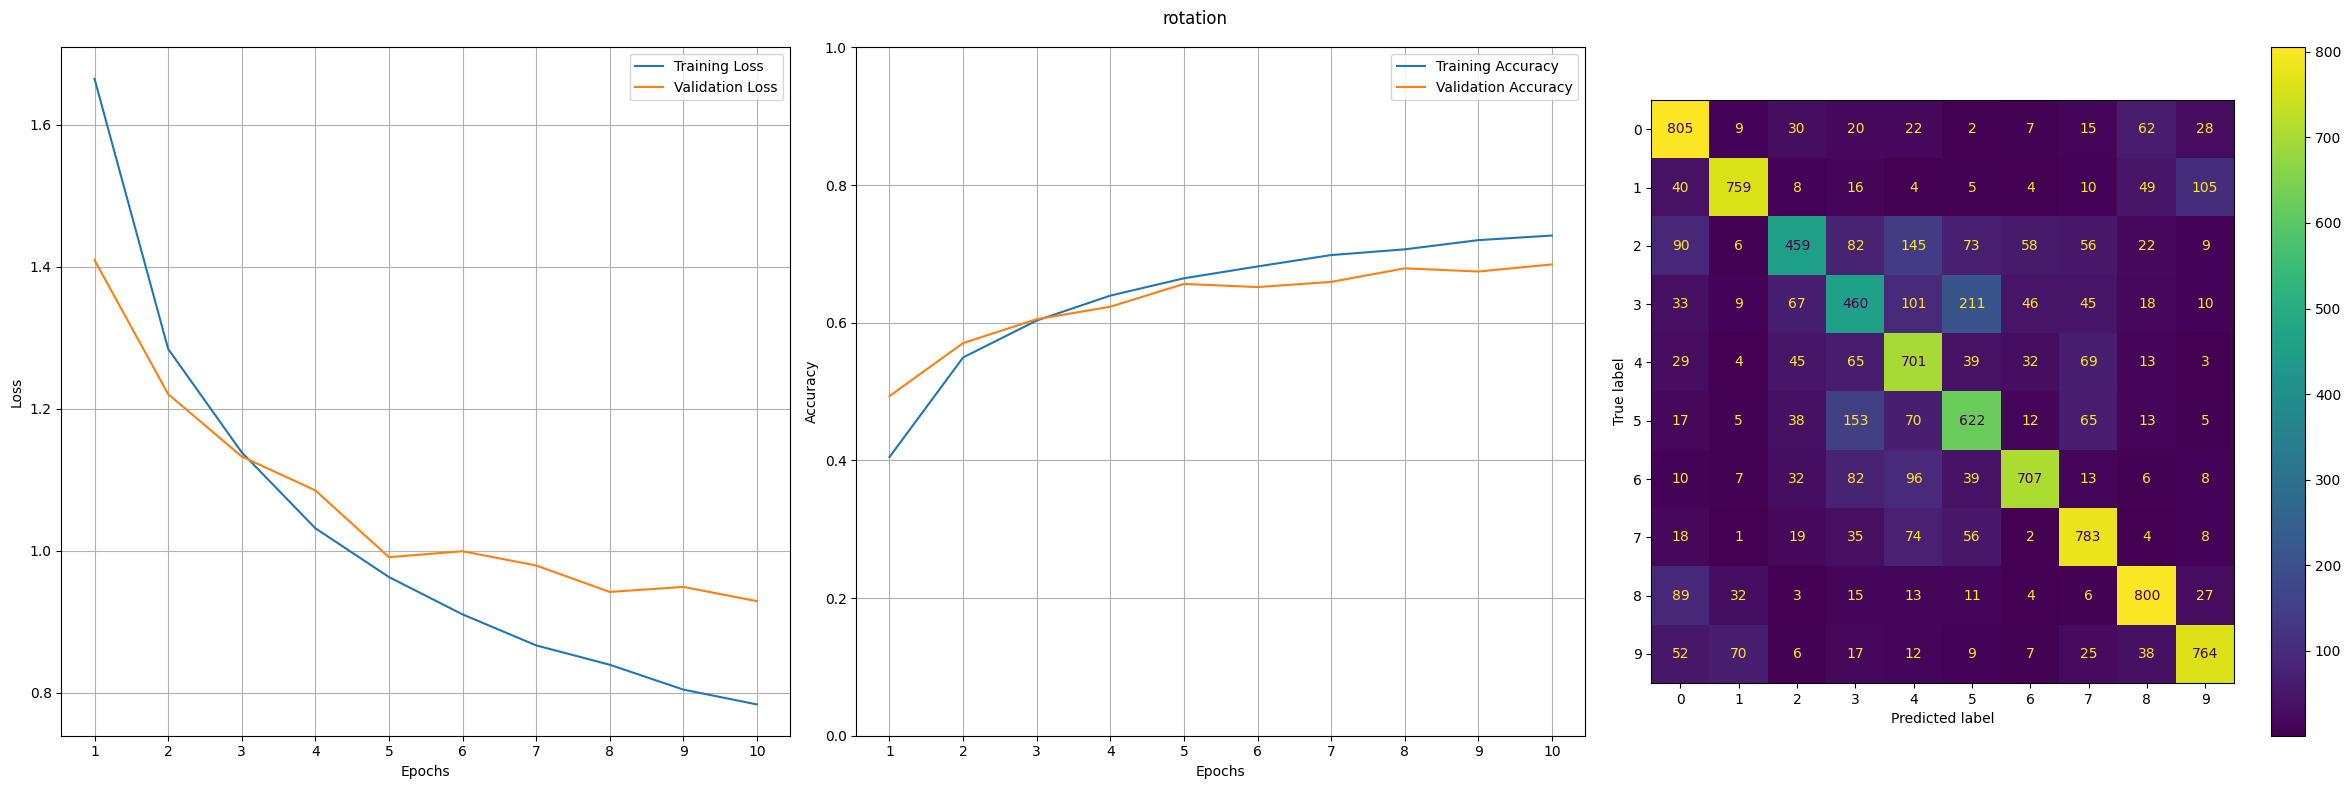

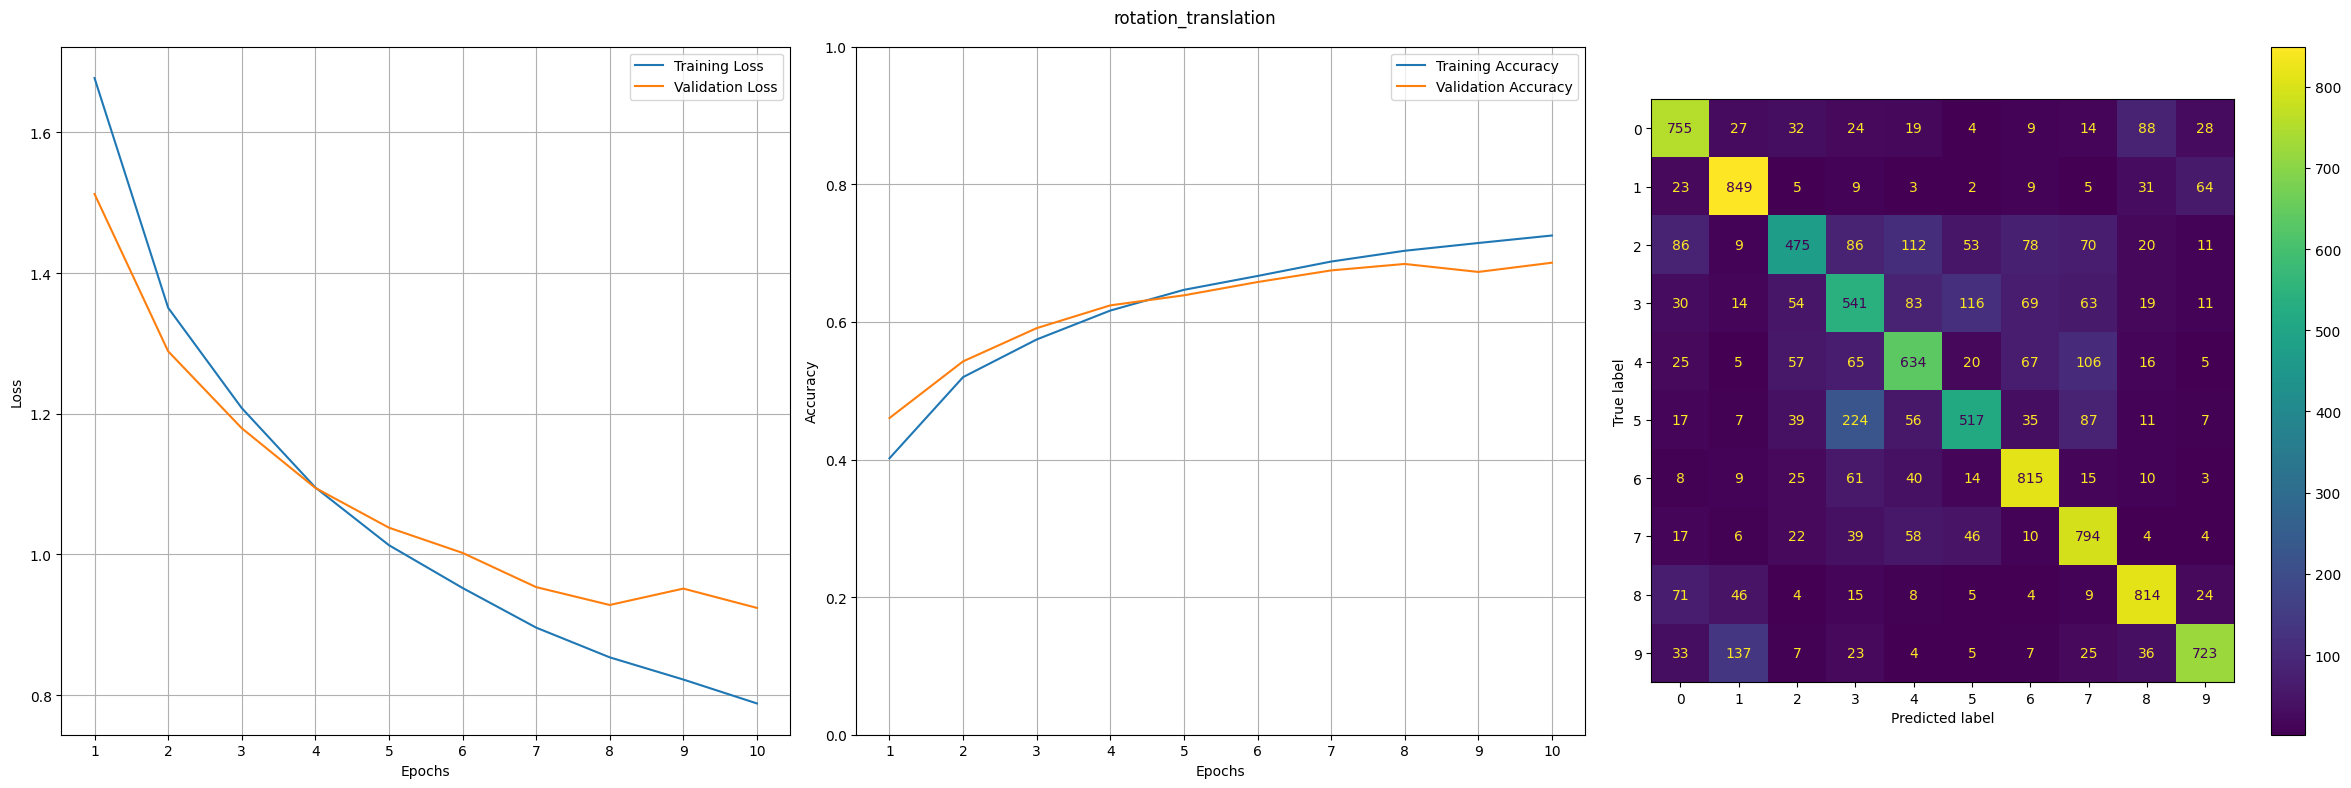

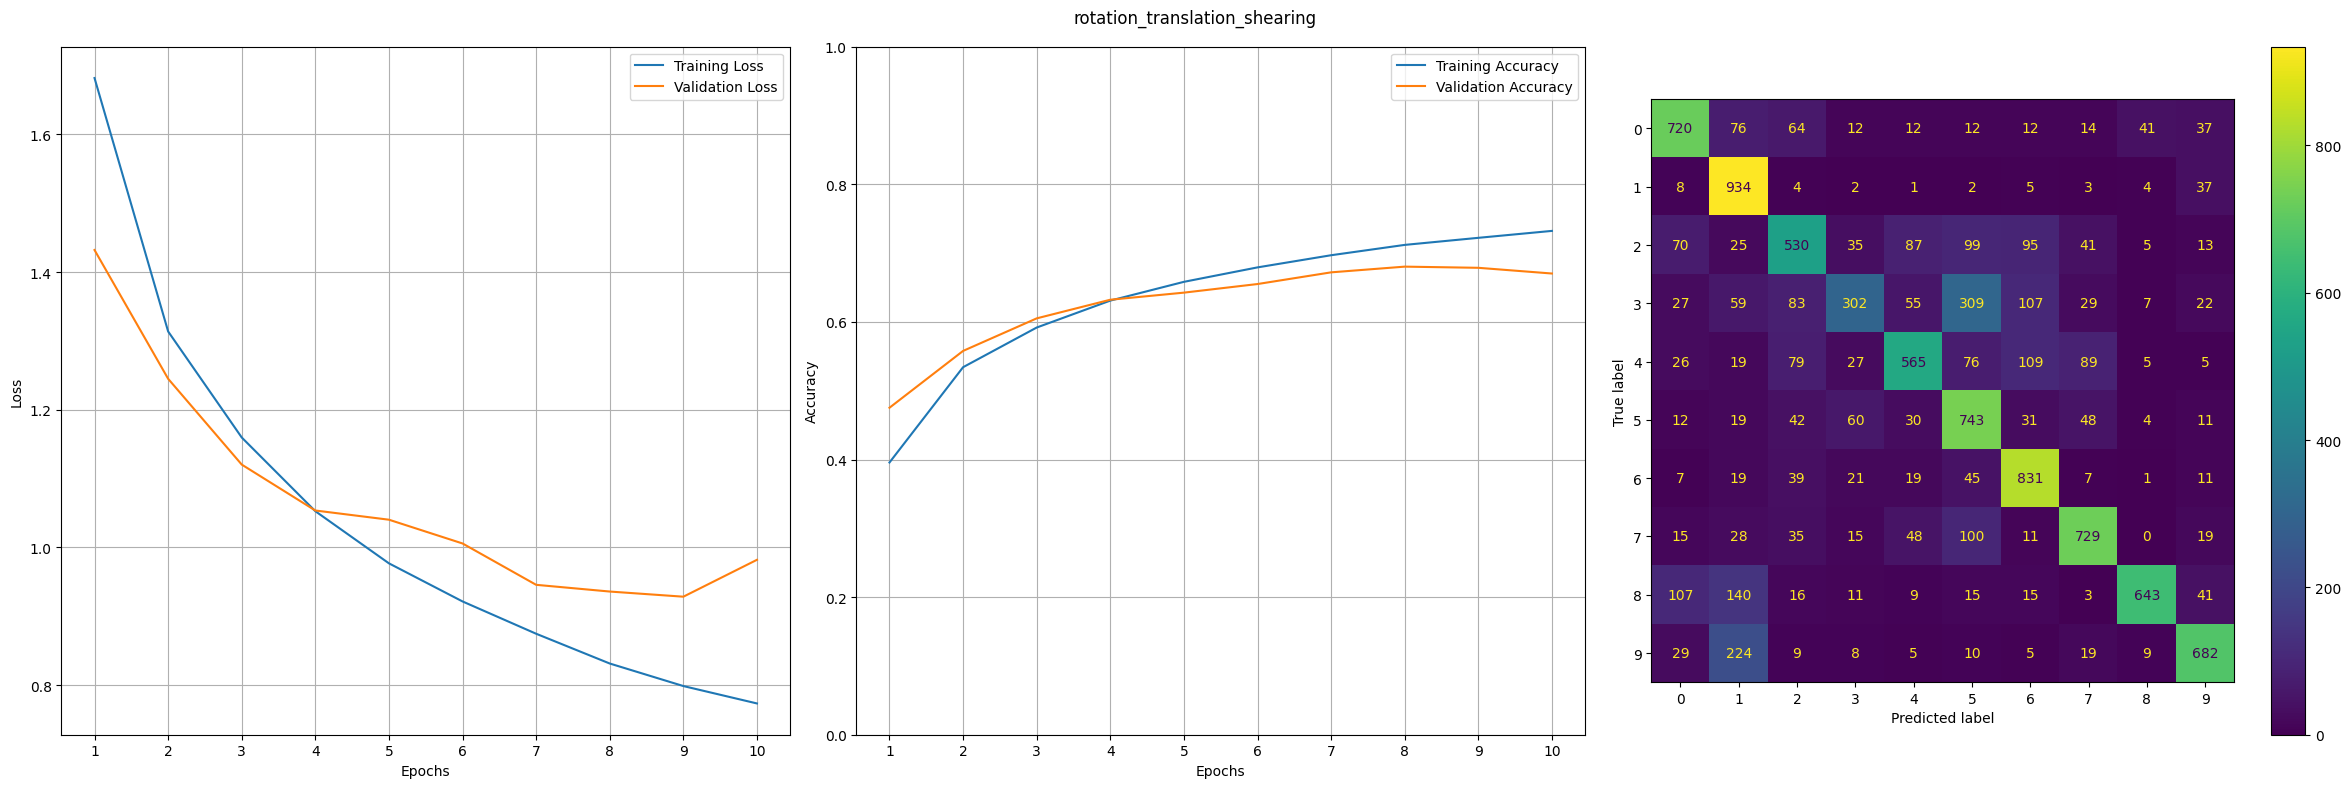

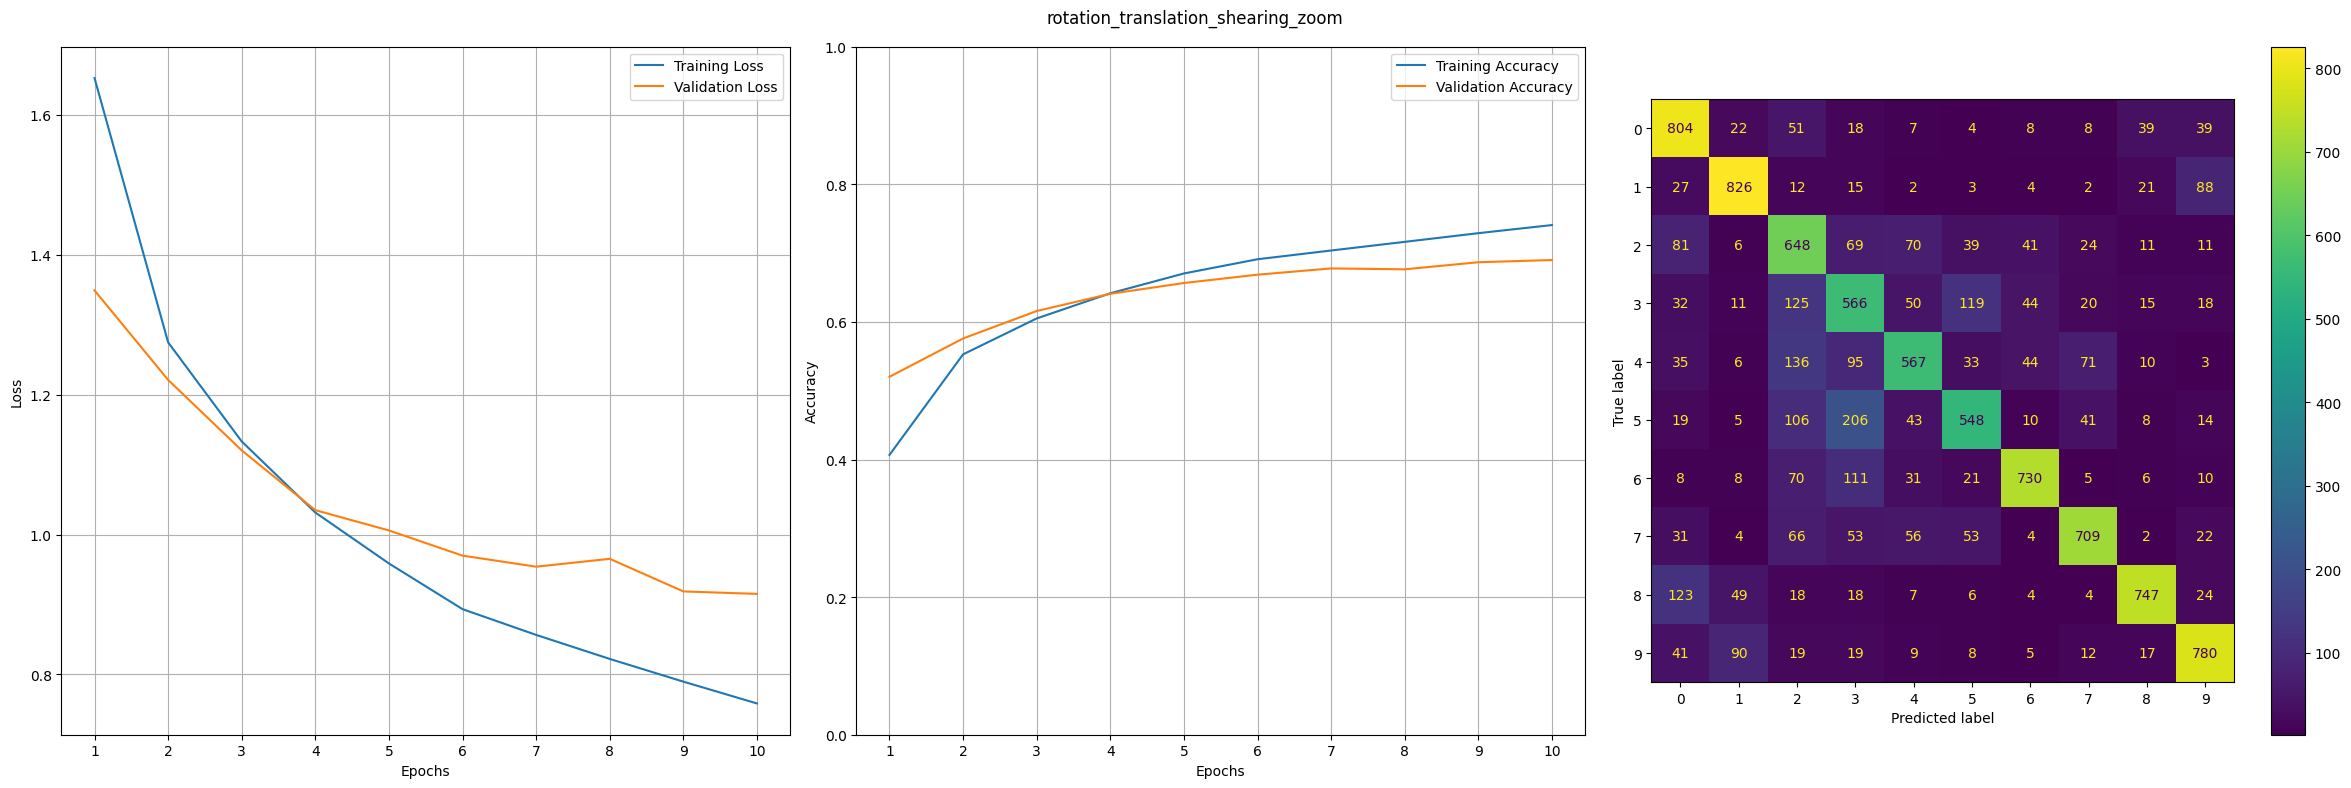

In [22]:
for i, name in enumerate(results.keys()):
    plot_loss_curve(n_epochs, results.get(name)[0], results.get(name)[1], results.get(name)[2], results.get(name)[3], results.get(name)[4], results.get(name)[5], title=name)

In [23]:
for i, name in enumerate(results.keys()):
    print(f'CNN: {name}, Train Accuracy: {results.get(name)[-2]:.2f}, Test Accuracy: {results.get(name)[-1]:.2f}')

CNN: rotation, Train Accuracy: 0.73, Test Accuracy: 0.69
CNN: rotation_translation, Train Accuracy: 0.73, Test Accuracy: 0.69
CNN: rotation_translation_shearing, Train Accuracy: 0.73, Test Accuracy: 0.67
CNN: rotation_translation_shearing_zoom, Train Accuracy: 0.74, Test Accuracy: 0.69


### Table of results

Describe your data augmentation strategies here.

| CNN | Architecture description | Acc. train | Acc. test |
|-----|--------------------------|------------|-----------|
|  No DA | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.74  | 0.69 |
| With rotation | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.73 | 0.69 | 
| With rotation_translation | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.73 | 0.69 |
| With rotation_translation_shearing | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.73 | 0.67 |
| With rotation_translation_shearing_zoom | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.74 | 0.69 |

a) Do you observe an improvement using data augmentation?\
It seems that data augmentation does not improve performance.

b) Compare the evolution of the loss through the training epochs, with and without using data augmentation.\
The loss looks similar for all variations. It seems that the model starts to overfit around 5 epochs.

c) If you tried with different data augmentation strategies, which one seems to give the best results?\
All of them give similar results.

## Visualizing What My Model Learns

It’s often said that deep-learning models are “black boxes”: learning representations that are difficult to extract and present in a human-readable form. Although this is partially true for certain types of deep-learning models, it’s definitely not true for convnets. The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual concepts.
Here we attempt to visualize the intermediate CNN outputs (intermediate activations). Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its activation, the output of the activation function). This gives a view into how an input is decomposed into the different filters learned by the network.
We want to visualize feature maps with three dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.

In [24]:
train_data = datasets.CIFAR10(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)

Size: torch.Size([3, 32, 32]), Label: 7


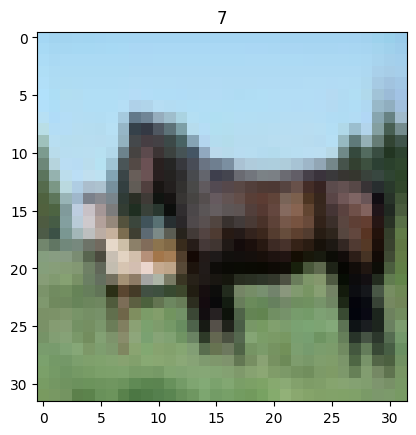

In [25]:
# visualize image number 12
img, label = train_data[12]
print(f'Size: {img.size()}, Label: {label}')
plt.imshow(img.permute(1, 2, 0))
plt.title(label)
plt.show()

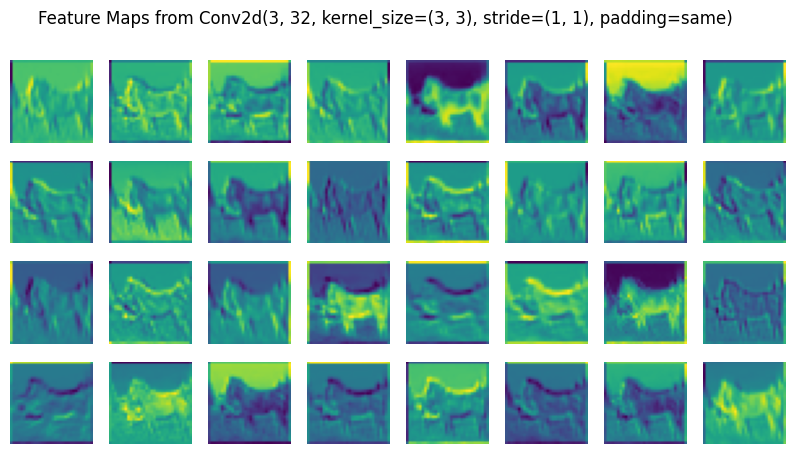

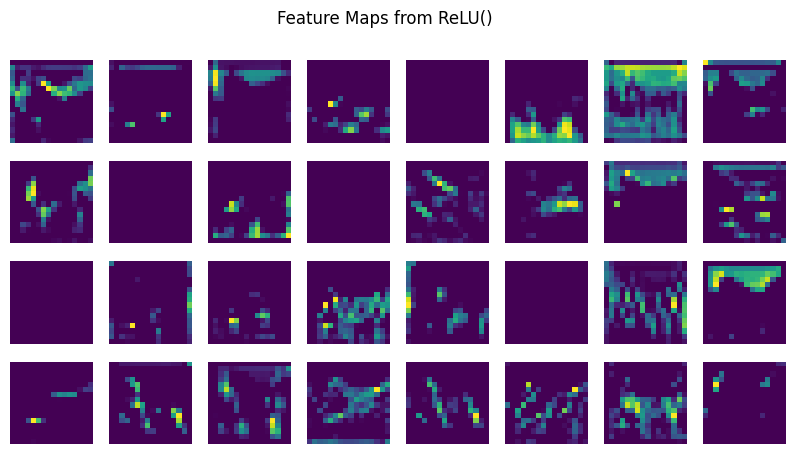

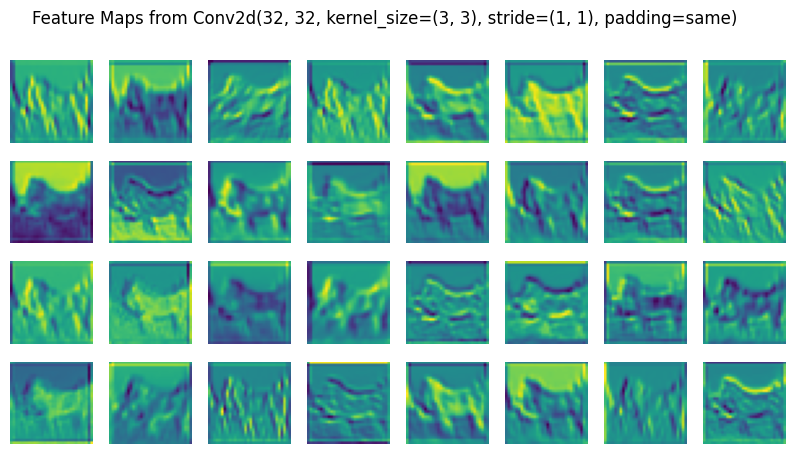

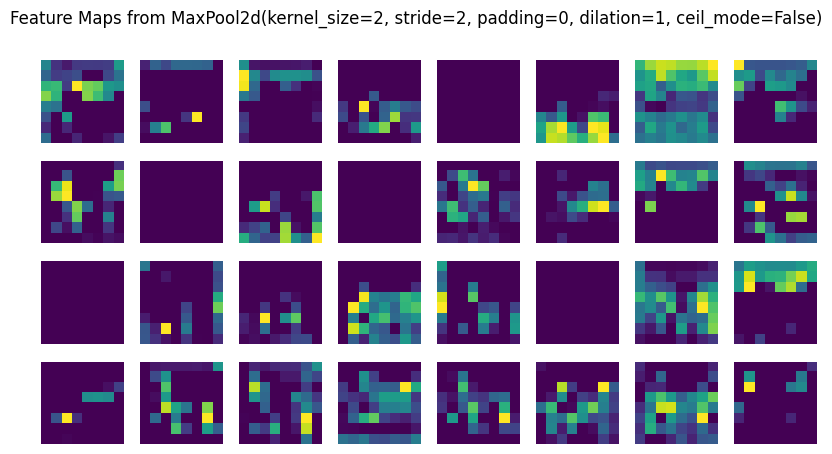

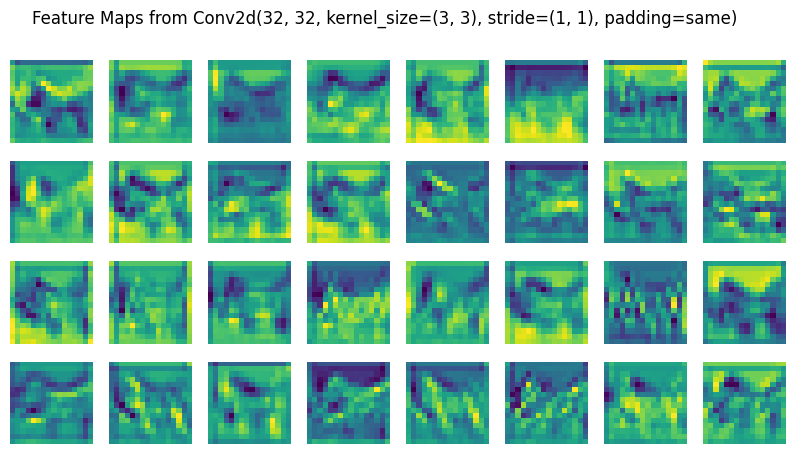

In [27]:
#  Now implement a code to visualise all the filters at a given layer. 
#  Hints : use subplots to have a grid of images, use for loops to avoid code repetition.

activations = {}

def hook_fn(module, input, output):
    activations[module] = output.detach()

for layer in [model.conv1, model.conv2, model.conv3, model.relu, model.max_pool]:
    layer.register_forward_hook(hook_fn)

_ = model(img.unsqueeze(0).to(device))

def visualize_activation_maps(activation, title):
    num_filters = activation.shape[1]
    fig, ax = plt.subplots(4,8, figsize=(10, 5))
    ax = ax.flatten()

    for i in range(min(num_filters, len(ax))):
        ax[i].imshow(activation[0, i].cpu().numpy(), cmap='viridis')
        ax[i].axis('off')

    plt.suptitle(title)
    plt.show()

for layer, activation in activations.items():
    visualize_activation_maps(activation, f'Feature Maps from {layer}')

## Optional : Deeper Models
Let's play here with a deeper CNN model on CIFAR10 using a structure inspired by VGGNet: [[Conv2D $\rightarrow$ relu $\rightarrow$ BN]*3 $\rightarrow$ MaxPool2D $\rightarrow$ Dropout]*4 $\rightarrow$ Flatten $\rightarrow$ Dense $\rightarrow$ Dropout $\rightarrow$ Out.
In this structure, BN means Batch Normalisation. You can try different options but a configuration with blocks of 64 filters of size 3 with same padding and stride 1, max pooling of size 2 and stride 2, dropouts of 0.2 and a dense layer of 256 neurons should bring your performance around 80-85\% on CIFAR10.

You probably  need to use a GPU to train such networks and play with different settings. You may use freely available GPUs on Colab, see https://colab.research.google.com/
To activate the gpu on Colab, go to Edit > Notebook settings and select GPU.}. Report your best performances with and without data augmentation as in Exercise 1. What are your observations.

In [ ]:
#  Your code here

## Analysis of a Deep Architecture

The analysis of the deep CNN architectures we did in the class covered the evolution observed on the ImageNet LSVRC competition until 2017. New architectures were introduced after that, such as for exemple the **Inception-v4**, **XCeption**, **EfficientNet**, etc. Other strategies based on deep CNNs have also emerged for other tasks such as *image detection* (finding bounding boxes around the objects of interest), such as **Yolo** (v1 to v6).

- Pick one of these new architectures that you find interesting (Inception-v4, XCeption, EfficientNet, Yolo, or another one).
- List and provide the reference(s) explaining the architecture (at least the reference to the original paper(s) presenting the architecture).
- Read the article(s) up to the point you have a general understanding of their strategy - no need to understand all the details!
- Re-explain in few phrases what you understood from the architecture doing comparison with the architectures presented in the class.

YOUR REPORT ABOUT A CHOSEN ARCHITECTURE HERE 

We decided on YOLOv12: https://arxiv.org/abs/2502.12524.

YOLOv12 is the first YOLO model to incorporate the Vision Transformer (ViT). Previously, ViTs were avoided due to their significantly higher computational cost and slower performance compared to traditional CNNs. This is because attention mechanisms scale quadratically with the number of parameters and calculations, whereas CNNs scale linearly. YOLOv12 addresses this by introducing image splits, reducing complexity to a level that is greater than linear but less than quadratic.  Additionally, the model adopts an MLP ratio of 1.2 instead of the typical 4 used in most ViTs, further decreasing the number of parameters. Another notable aspect is the choice of optimizer, YOLOv12 employs SGD, whereas modern deep-learning models more commonly use Adam or AdamW in practice.

## Optional: Review Questions

See pdf of this Practical Work for the review questions.